## This colab notebook makes predictions for any desired time range using MMS data.

## Installing the required packages

In [15]:
!pip install --quiet pyspedas

## Choose a timerange

In [20]:
## Dayside cases
# trange = ['2019-11-09/00:05:00', '2019-11-09/23:59:00']
# trange = ['2019-12-07/00:05:00', '2019-12-07/23:59:00']
trange = ['2023-04-17/00:00:00', '2023-04-17/23:59:00']
# trange = ['2025-03-10/00:00:00', '2025-03-10/23:59:00']

## Nightside cases
# trange = ['2019-07-13/00:00:00', '2019-07-13/23:59:00']
# trange = ['2022-07-18/00:00:00', '2022-07-18/23:59:00']
# trange = ['2021-08-31/00:00:00', '2021-08-31/23:59:00']
# trange = ['2024-08-24/00:00:00','2024-08-24/23:59:00']

## Flank casea
# trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00'] # flank
# trange = ['2015-09-19/00:07:00', '2015-09-19/20:00:00'] # flank

## Downloading the Models

In [3]:
import gdown


url = "https://drive.google.com/uc?export=download&id=1RIbKG4aLhgbg0lpBt-HJebeSvmmbKdSf"
output = 'model_cnn.pth'
gdown.download(url, output, quiet=False)

url = "https://drive.google.com/uc?export=download&id=1CCe1Yc07Yp6RIC3Xq-K1eV4HW8BGtMJC"
output = 'model_rf.pkl'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?export=download&id=1RIbKG4aLhgbg0lpBt-HJebeSvmmbKdSf
To: /content/model_cnn.pth
100%|██████████| 623k/623k [00:00<00:00, 80.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1CCe1Yc07Yp6RIC3Xq-K1eV4HW8BGtMJC
To: /content/model_rf.pkl
100%|██████████| 432k/432k [00:00<00:00, 79.8MB/s]


'model_rf.pkl'

## Downloading utility files

In [8]:

#https://drive.google.com/file/d/1BVSDAdGr9y-W7QNWo_dYCnJJomYCTNrC/view?usp=sharing
url = "https://drive.google.com/uc?export=download&id=1BVSDAdGr9y-W7QNWo_dYCnJJomYCTNrC"
output = 'colab_utils.py'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1BVSDAdGr9y-W7QNWo_dYCnJJomYCTNrC
From (redirected): https://drive.google.com/uc?export=download&id=1BVSDAdGr9y-W7QNWo_dYCnJJomYCTNrC&confirm=t&uuid=edfef471-d00d-45d9-a0a3-42a70a44ad8c
To: /content/colab_utils.py
100%|██████████| 11.9k/11.9k [00:00<00:00, 22.7MB/s]


'colab_utils.py'

In [9]:
from colab_utils import FluxCNNModel

## Initialize the models

In [10]:
import torch
# Instantiate a fresh instance of multiinputmodel
loaded_CNN = FluxCNNModel()
# RFModel = rf()



# Load model state dict
loaded_CNN.load_state_dict(torch.load(f="/content/model_cnn.pth"))

print(f"Loaded model:\n{FluxCNNModel}")

Loaded model:
<class 'colab_utils.FluxCNNModel'>


In [11]:
# Load RF model
import joblib
from sklearn.ensemble import RandomForestClassifier
RF_MODEL_SAVE_PATH = '/content/model_rf.pkl'
loaded_rf = joblib.load(RF_MODEL_SAVE_PATH)
print("Loaded model:", loaded_rf)

26-Sep-25 21:30:07: /usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(

26-Sep-25 21:30:07: /usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Loaded model: RandomForestClassifier(random_state=42)


In [12]:
cnn_model = loaded_CNN
rf_model = loaded_rf

## Make Predictions
### Leave the request for SDC password blank!

In [13]:
from colab_utils import predictions_cnn_rf

26-Sep-25 21:45:52: pydata/mms1/fgm/srvy/l2/2023/04/mms1_fgm_srvy_l2_20230417_v5.398.0.cdf
26-Sep-25 21:45:42: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

26-Sep-25 21:45:42: Loading files for group: probe: 1, drate: srvy, level: l2, datatype: , after sorting and filtering:
26-Sep-25 21:46:05: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

26-Sep-25 21:46:05: Loading files for group: probe: 1, drate: fast, level: l2, datatype: dis-moms, after 

x1 shape :  torch.Size([403, 40, 32])


  0%|          | 0/51 [00:00<?, ?it/s]

26-Sep-25 21:46:59: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

26-Sep-25 21:46:59: /content/colab_utils.py:291: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')

26-Sep-25 21:47:10: /usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



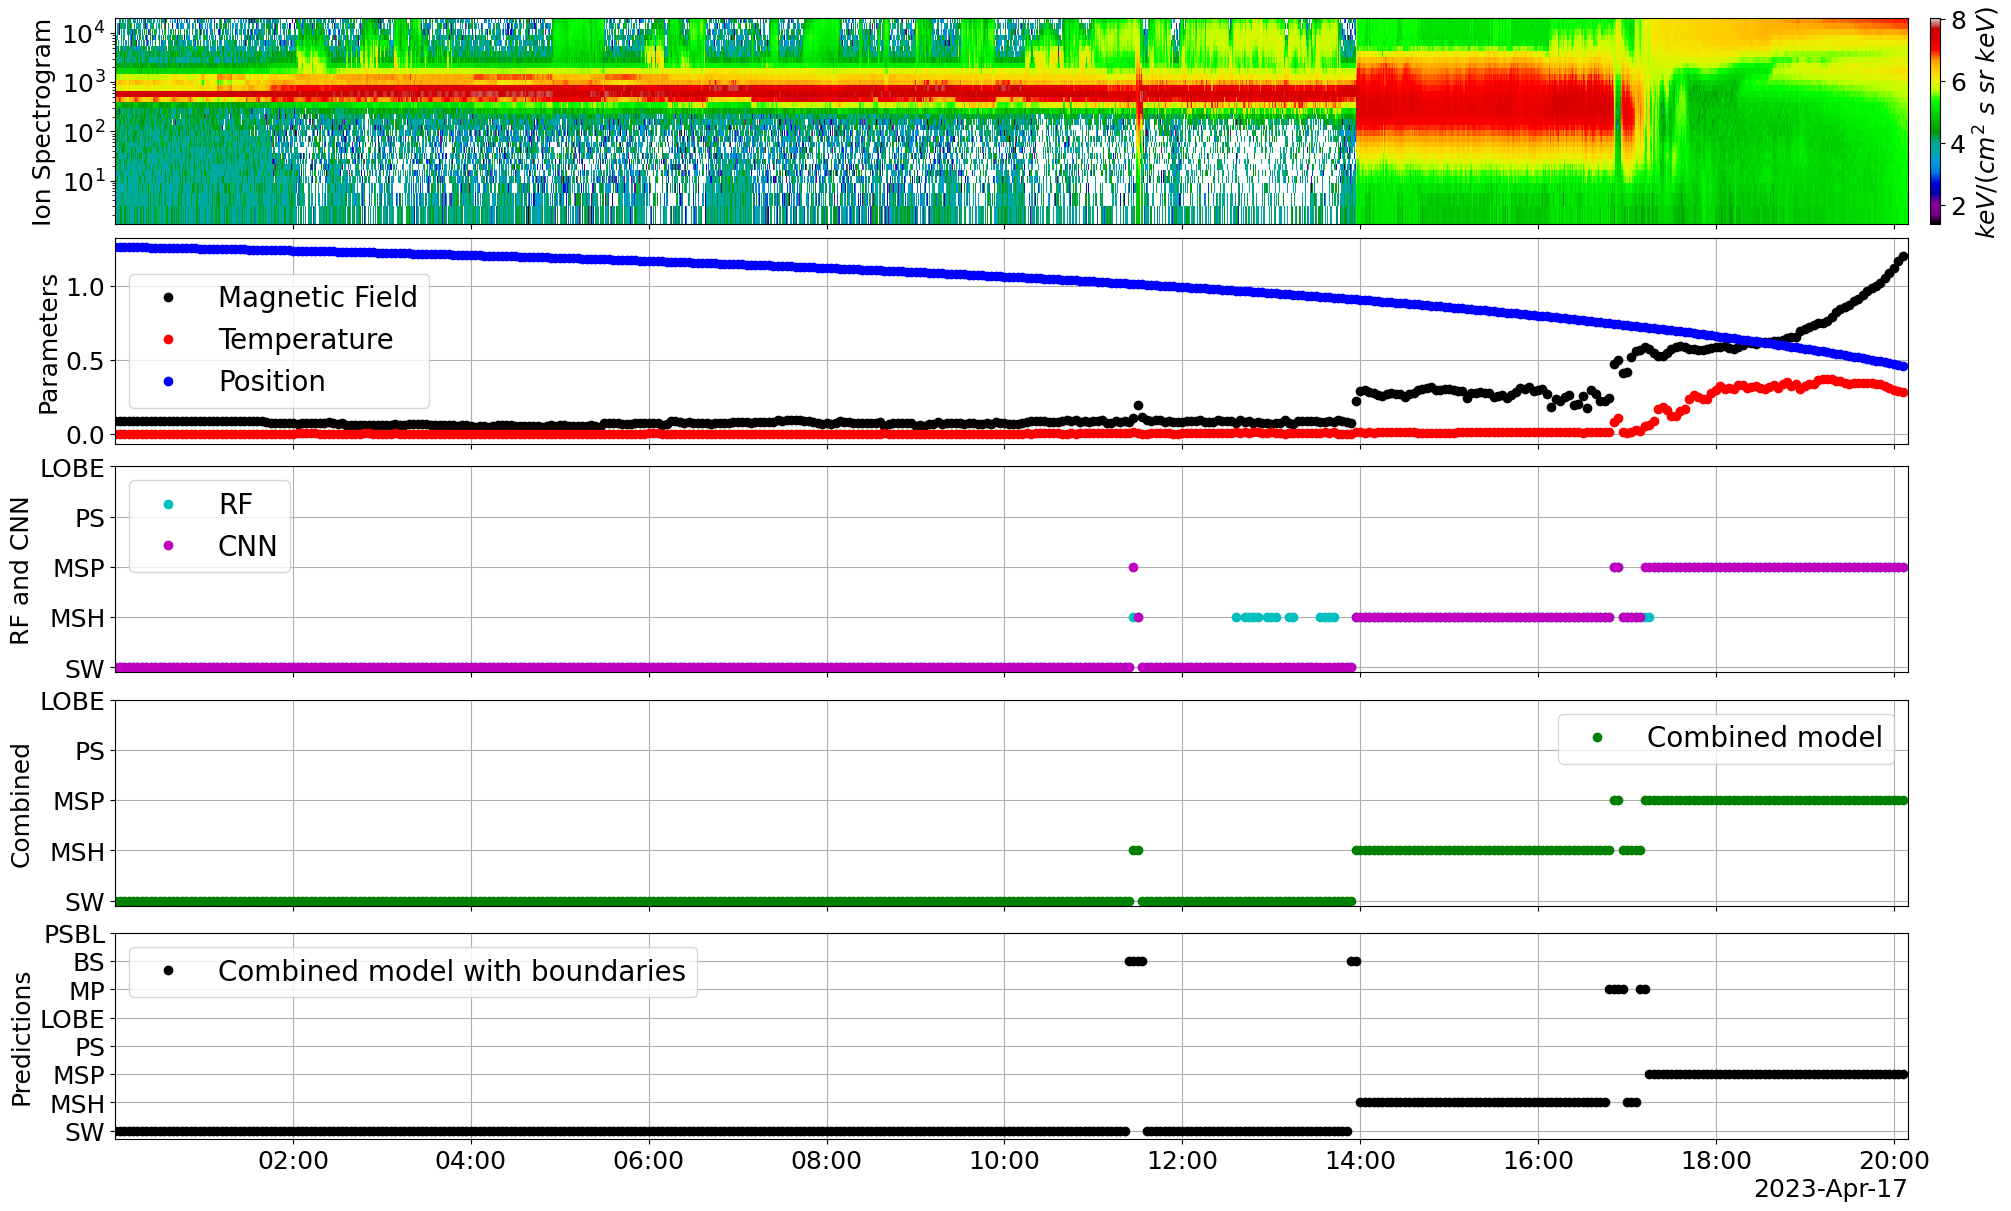

In [21]:
predictions_cnn_rf(cnn_model=cnn_model, rf_model=rf_model, trange=trange)